### Assignment 3
### Prepared By: Woon Kim
### UNI: wk2371
### Course: ACTU 5841
### Date: February 13 2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#filtering observations with FACE >= 50000
df = pd.read_csv('TermLifeData.csv')
df = df[df['FACE']  >= 50000]
df.head()

,MARSTAT,EDUCATION,NUMHH,INCOME,FACE
1,1,9,3,12000,130000
2,1,16,5,120000,1500000
3,1,17,4,40000,50000
5,2,11,4,28000,220000
7,1,16,3,100000,600000


In [3]:
#part [a]

In [4]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'box-cox', standardize = False)

# reshaping the column FACE to be in the appropriate dimension for box-cox transformation
FACEbc = np.asarray(df['FACE'])
FACEbc = FACEbc.reshape(-1,1)

# converting type of FACE to float instead of int
# so that I can convert 0 to a very small number instead (box-cox only works for strictly positive values)
FACEbc = FACEbc.astype(float)
FACEbc[FACEbc == 0] = 0.0000000001

pt.fit(FACEbc)
pt.lambdas_

#Adding the transformed FACE values into a new column on dataframe
FACEbc = pt.transform(FACEbc)
df['FACEbc'] = FACEbc

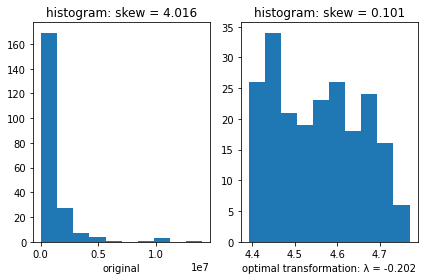

In [5]:
skew1 = round(df['FACE'].skew(),3)
skew2 = round(df['FACEbc'].skew(),3)
lambdas = pt.lambdas_[0]

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(df['FACE'])
ax1.set_title('histogram: skew = %s' % skew1)
ax1.set_xlabel('original')

ax2.hist(df['FACEbc'])
ax2.set_title('histogram: skew = %s' % skew2)
ax2.set_xlabel('optimal transformation: %s = %s' % (chr(0x03BB), round(lambdas,3)))

plt.tight_layout()
plt.savefig("histogram.png")


In [6]:
#part [b]

In [7]:
#creating dummy variables for the categorical variable MARSTAT 
df_dc = pd.get_dummies(df, columns=['MARSTAT'])
df_dc.head()

,EDUCATION,NUMHH,INCOME,FACE,FACEbc,MARSTAT_0,MARSTAT_1,MARSTAT_2
1,9,3,12000,130000,4.489410,0,1,0
2,16,5,120000,1500000,4.667959,0,1,0
3,17,4,40000,50000,4.391879,0,1,0
5,11,4,28000,220000,4.535591,0,0,1
7,16,3,100000,600000,4.611143,0,1,0


In [8]:
#Adding ln(INCOME) as a new column on the dataframe 
df_dc['logINCOME'] = np.log(df_dc['INCOME'])

In [9]:
#Computing linear regression
#Formula FACEbc = B0 + B1*EDUCATION + B2*NUMHH + B3*logINCOME + B4*MARSTAT_0 + B5*MARSTAT_2 + E
from sklearn.linear_model import LinearRegression
X = df_dc[['EDUCATION', 'NUMHH', 'logINCOME', 'MARSTAT_0', 'MARSTAT_2']]
y = df_dc['FACEbc']
reg = LinearRegression().fit(X, y)
B = reg.coef_
B = np.insert(B, 0, reg.intercept_, axis=0)
print(B)

[ 4.054996    0.01335962  0.00759392  0.02511296 -0.04642982 -0.01841342]


In [10]:
#Computing standard error with n-1 degrees of freedom
SE = np.std(y, ddof=1)
print(SE)

0.10323297449402534


In [11]:
#Computing R2
y_pred = reg.predict(X)
from sklearn.metrics import r2_score
R2 = r2_score(y, y_pred)
print(R2)

0.33359974845365026


In [12]:
#part [c]

In [13]:
df_dc.head()

,EDUCATION,NUMHH,INCOME,FACE,FACEbc,MARSTAT_0,MARSTAT_1,MARSTAT_2,logINCOME
1,9,3,12000,130000,4.489410,0,1,0,9.392662
2,16,5,120000,1500000,4.667959,0,1,0,11.695247
3,17,4,40000,50000,4.391879,0,1,0,10.596635
5,11,4,28000,220000,4.535591,0,0,1,10.239960
7,16,3,100000,600000,4.611143,0,1,0,11.512925


In [14]:
"""
from statsmodels.formula.api import ols
dta = df_dc
formula = 'FACEbc ~ EDUCATION + NUMHH + logINCOME + MARSTAT_0 + MARSTAT_2'
results = ols(formula, dta).fit()
hypotheses = 'MARSTAT_0 = 0, MARSTAT_2 = 0'
t_test = results.t_test(hypotheses)
print(t_test)
"""

"\nfrom statsmodels.formula.api import ols\ndta = df_dc\nformula = 'FACEbc ~ EDUCATION + NUMHH + logINCOME + MARSTAT_0 + MARSTAT_2'\nresults = ols(formula, dta).fit()\nhypotheses = 'MARSTAT_0 = 0, MARSTAT_2 = 0'\nt_test = results.t_test(hypotheses)\nprint(t_test)\n"

In [15]:
#Conducting linear regression using OLS method
import statsmodels.api as sm

X = df_dc[['EDUCATION', 'NUMHH', 'logINCOME', 'MARSTAT_0', 'MARSTAT_2']]
y = df_dc['FACEbc']

X2 = sm.add_constant(X)

lm = sm.OLS(y, X2).fit()
print(lm.summary())

c:\Users\Woon\Documents\env_ds_3_10\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


                            OLS Regression Results                            
Dep. Variable:                 FACEbc   R-squared:                       0.334
Model:                            OLS   Adj. R-squared:                  0.318
Method:                 Least Squares   F-statistic:                     20.72
Date:                Thu, 21 Jul 2022   Prob (F-statistic):           9.13e-17
Time:                        18:47:52   Log-Likelihood:                 225.17
No. Observations:                 213   AIC:                            -438.3
Df Residuals:                     207   BIC:                            -418.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.0550      0.060     67.405      0.0

In [16]:
#part [d]

In [17]:
#Conducting prediction with the married man profile as described from the question
X3 = np.array([['16', '4', np.log(120000), '0', '0']])
Y3 = reg.predict(X3)

#Inversing the box-cox transformation for the prediction
Y3 = Y3.reshape(-1,1)
Y3 = pt.inverse_transform(Y3)

#Inversing the box-cox transformation of the standard error
SE = SE.reshape(-1,1)
SE = pt.inverse_transform(SE)

#Computing upper and lower interval
Y3_upper, Y3_lower = Y3+SE, Y3-SE

print('95%% likelihood that the true value is between $%.2f and $%.2f' % (Y3_lower, Y3_upper))
print('True value: $%.2f' % Y3)

95% likelihood that the true value is between $461451.11 and $461453.33
True value: $461452.22


c:\Users\Woon\Documents\env_ds_3_10\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\Woon\Documents\env_ds_3_10\lib\site-packages\sklearn\base.py:566: FutureWarning: Arrays of bytes/strings is being converted to decimal numbers if dtype='numeric'. This behavior is deprecated in 0.24 and will be removed in 1.1 (renaming of 0.26). Please convert your data to numeric values explicitly instead.
  X = check_array(X, **check_params)
